In [50]:
# import relevant libraries

import pandas as pd
from sklearn.metrics import classification_report

In [51]:
# load data into dataframe

df_2024 = pd.read_csv(r"C:\Users\Abhimanyu\Desktop\Github\DSCapstone\ML\content\combined_data.csv")

In [52]:
print(df_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554119 entries, 0 to 554118
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   YEAR             554119 non-null  int64  
 1   MONTH            554119 non-null  int64  
 2   DAY              554119 non-null  int64  
 3   HOUR             554119 non-null  int64  
 4   MINUTE           554119 non-null  int64  
 5   SHIFT            554119 non-null  object 
 6   METHOD           554119 non-null  object 
 7   OFFENSE          554119 non-null  object 
 8   BLOCK            554119 non-null  object 
 9   WARD             554119 non-null  int64  
 10  ANC              554119 non-null  object 
 11  DISTRICT         554119 non-null  int64  
 12  PSA              554119 non-null  int64  
 13  VOTING_PRECINCT  554119 non-null  object 
 14  LATITUDE         554119 non-null  float64
 15  LONGITUDE        554119 non-null  float64
dtypes: float64(2), int64(8), object(6)
mem

In [53]:
# Drop rows where offense is "ARSON"
df_2024 = df_2024[df_2024["OFFENSE"] != "ARSON"]

In [54]:
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY',
       'MOTOR VEHICLE THEFT', 'BURGLARY', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [55]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ROBBERY": "THEFT", "BURGLARY": "THEFT"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"MOTOR VEHICLE THEFT" : "THEFT"})
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [56]:
df_2024["OFFENSE"].value_counts()

OFFENSE
THEFT                         513520
ASSAULT W/DANGEROUS WEAPON     33817
SEX ABUSE                       3784
HOMICIDE                        2620
Name: count, dtype: int64

In [57]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"HOMICIDE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"SEX ABUSE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ASSAULT W/DANGEROUS WEAPON" : "VIOLENT CRIME"})

df_2024["OFFENSE"].unique()

array(['THEFT', 'VIOLENT CRIME'], dtype=object)

In [58]:
df_2024["OFFENSE"].value_counts()

OFFENSE
THEFT            513520
VIOLENT CRIME     40221
Name: count, dtype: int64

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define X (features) and y (target)
x_independent = df_2024.drop(columns=["OFFENSE", "METHOD"])  # Drop the target variable
y_dependent = df_2024["OFFENSE"]  # Target variable

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_dependent)

# Define categorical and numerical columns
categorical_cols = ["SHIFT", "ANC", "VOTING_PRECINCT", "BLOCK"]  # Categorical features
numerical_cols = ["YEAR", "MONTH", "DAY", "HOUR", "MINUTE", "WARD", "DISTRICT", "PSA", "LATITUDE", "LONGITUDE"]  # Numerical features

# Label encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    x_independent[col] = le.fit_transform(x_independent[col])

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(x_independent, y_encoded, test_size=0.20, random_state=42)

# Print shapes of the training and test sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (442992, 14), X_test shape: (110749, 14)
y_train shape: (442992,), y_test shape: (110749,)


In [60]:
print(label_encoder.classes_)

['THEFT' 'VIOLENT CRIME']


In [61]:
from imblearn.under_sampling import RandomUnderSampler

# "THEFT" is the majority class (label 0) that needs to undersample

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state = 42, sampling_strategy = {0: 40221})

# Resample the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled contain the undersampled data

In [62]:
from imblearn.over_sampling import SMOTE
sampling_strategy = {1: 40221}  # Specify the label and desired number of samples

smote = SMOTE(sampling_strategy = sampling_strategy, random_state = 42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [63]:
# Check the new class distribution
print(f"Original class distribution:\n{y_train.shape}")
print(f"Resampled class distribution:\n{y_resampled.shape}")

Original class distribution:
(442992,)
Resampled class distribution:
(80442,)


In [64]:
from xgboost import XGBClassifier

# Create and configure the XGBoost model
model_xgb = XGBClassifier(
    eval_metric = "mlogloss",         # Set evaluation metric for multi-class classification
    random_state = 42,
    n_estimators = 1000,
    learning_rate = 0.01,
    max_depth = 11,
    min_child_weight = 1,
    subsample = 0.8,
    colsample_bytree = 0.6,
    scale_pos_weight = None,
    tree_method = "hist"
)
# Fit the model
model_xgb.fit(X_resampled, y_resampled, verbose=True)

# Make predictions
y_pred = model_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    102679
           1       0.17      0.70      0.27      8070

    accuracy                           0.72    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.72      0.79    110749



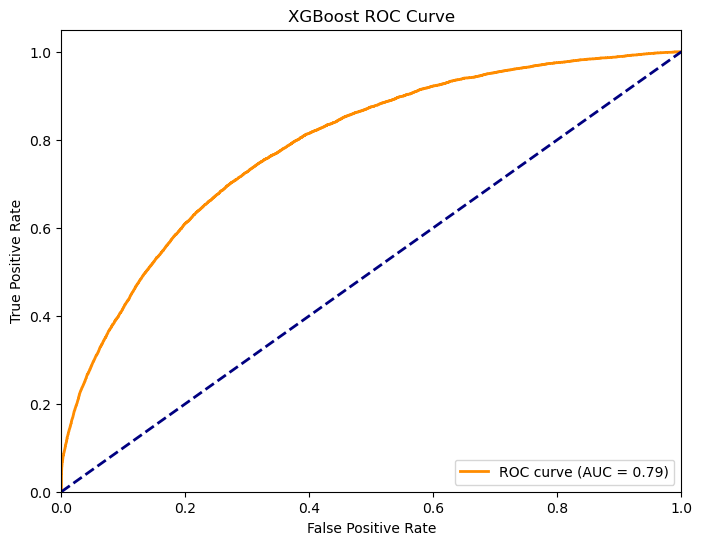

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc = "lower right")
plt.show()

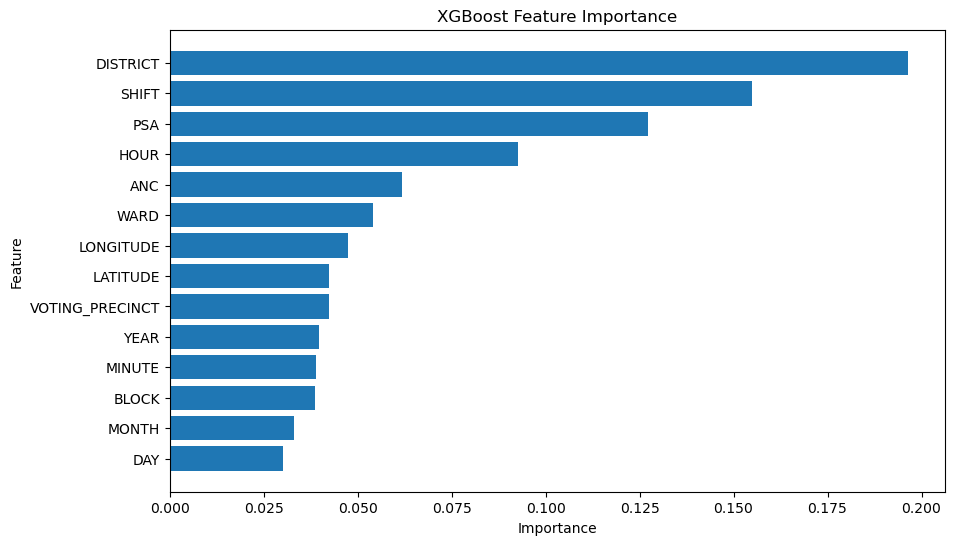

In [66]:
# Get feature importance
importance = model_xgb.feature_importances_


# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})


# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = True)


# Plot feature importance
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()


In [67]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter = 2000, random_state = 42, C = 100, penalty = "l1", solver = "liblinear")
# Fit the model
model_lr.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80    102679
           1       0.14      0.67      0.23      8070

    accuracy                           0.68    110749
   macro avg       0.55      0.68      0.52    110749
weighted avg       0.90      0.68      0.76    110749



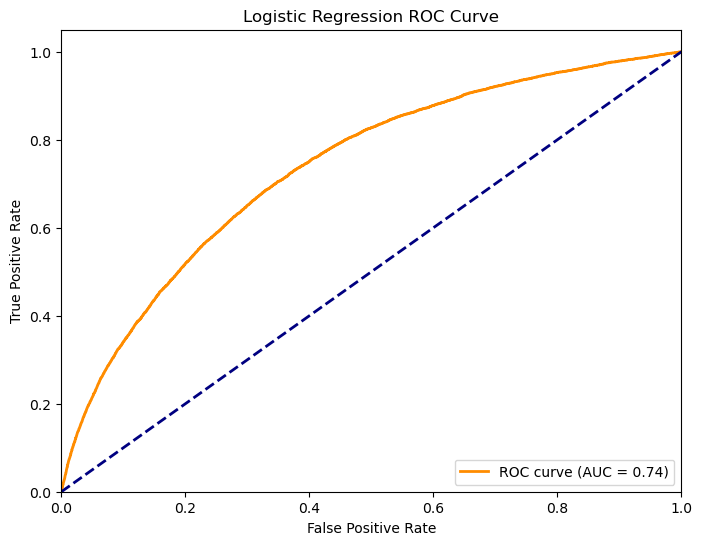

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lr.predict_proba(X_test)

# Assuming a binary classification problem (adjust if multi-class)
# For multi-class, you"ll need to loop through each class and plot ROC curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend(loc = "lower right")
plt.show()

In [70]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(learning_rate = 0.01, max_depth = 3, min_child_samples = 20, n_estimators = 100, num_leaves = 31)
# Fit the model
model_lgb.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 40221, number of negative: 40221
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 80442, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

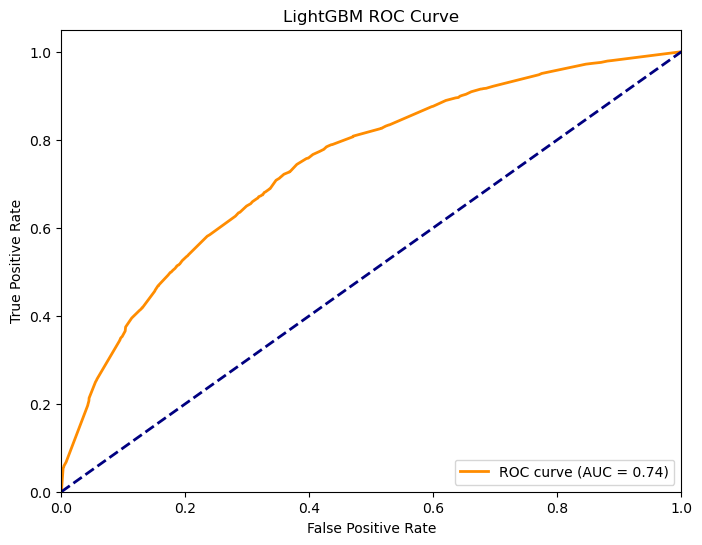

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM ROC Curve")
plt.legend(loc = "lower right")
plt.show()

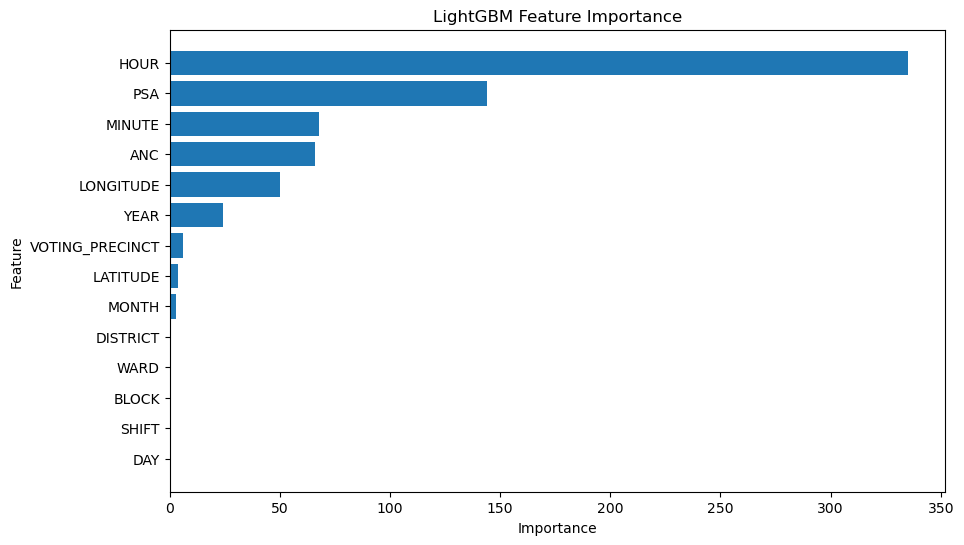

In [73]:
# Get feature importance
importance = model_lgb.feature_importances_


# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})


# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.show()


In [74]:
from catboost import CatBoostClassifier

model_cbc = CatBoostClassifier(silent = True, random_state = 42, border_count = 128, depth = 7, iterations = 1000, l2_leaf_reg = 5, learning_rate = 0.1)
# Fit the model
model_cbc.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_cbc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    102679
           1       0.17      0.70      0.27      8070

    accuracy                           0.72    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.72      0.79    110749



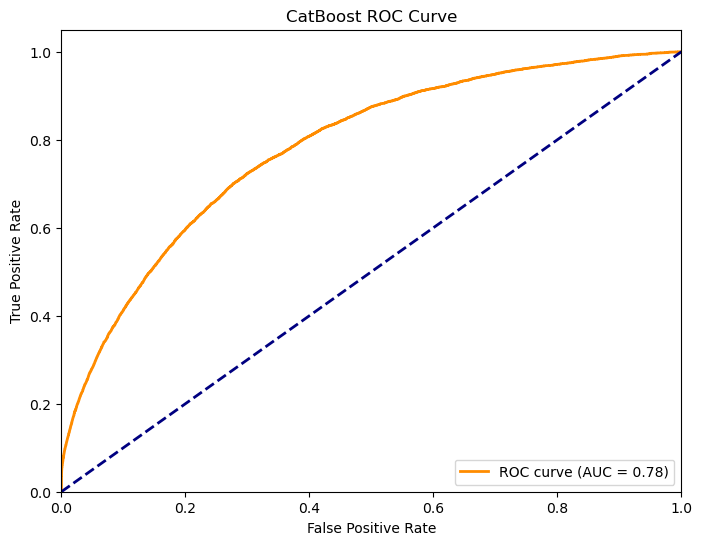

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_cbc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CatBoost ROC Curve")
plt.legend(loc = "lower right")
plt.show()

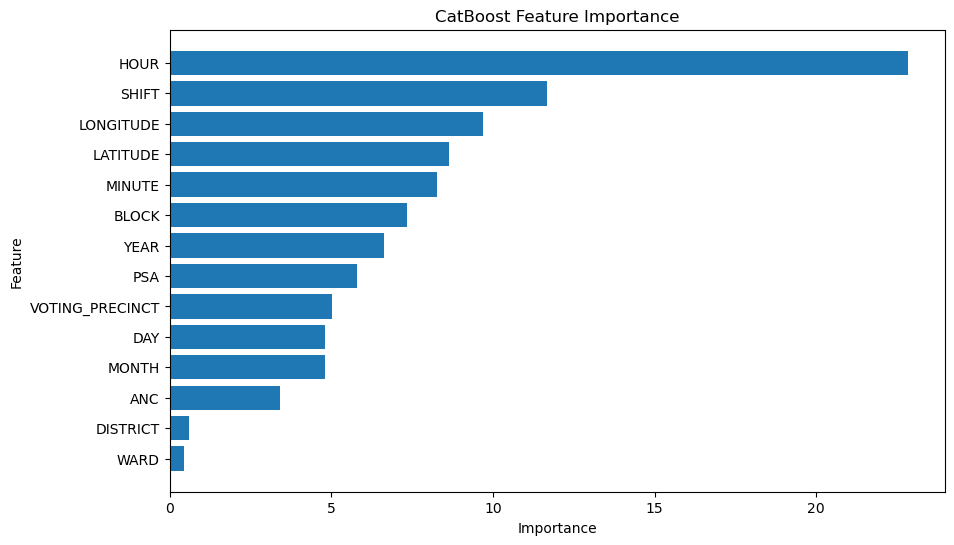

In [76]:
# Get feature importance
importance = model_cbc.feature_importances_


# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})


# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)


# Plot feature importance
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()


In [77]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(metric = "manhattan", n_neighbors = 11, weights = "distance")
# Fit the model
model_knn.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78    102679
           1       0.14      0.69      0.23      8070

    accuracy                           0.66    110749
   macro avg       0.55      0.67      0.51    110749
weighted avg       0.90      0.66      0.74    110749



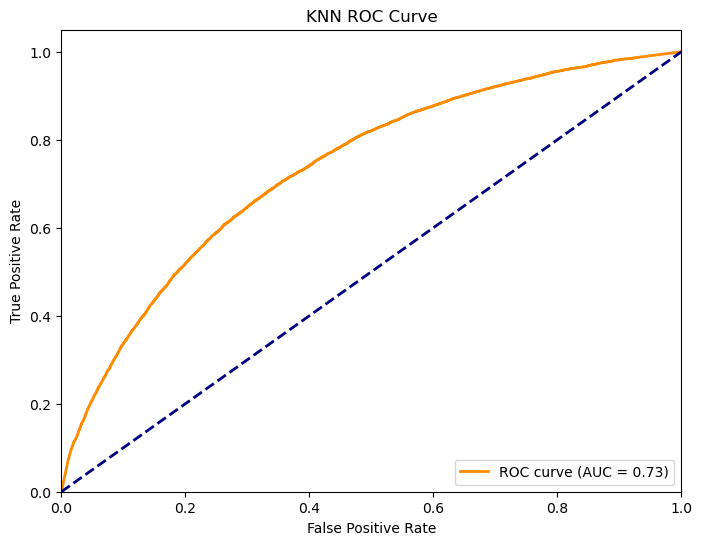

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve")
plt.legend(loc = "lower right")
plt.show()

In [81]:
from sklearn.naive_bayes import GaussianNB

model_naivebayes = GaussianNB(var_smoothing = 1e-09)
# Fit the model
model_naivebayes.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_naivebayes.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    102679
           1       0.14      0.63      0.23      8070

    accuracy                           0.69    110749
   macro avg       0.55      0.66      0.52    110749
weighted avg       0.90      0.69      0.76    110749



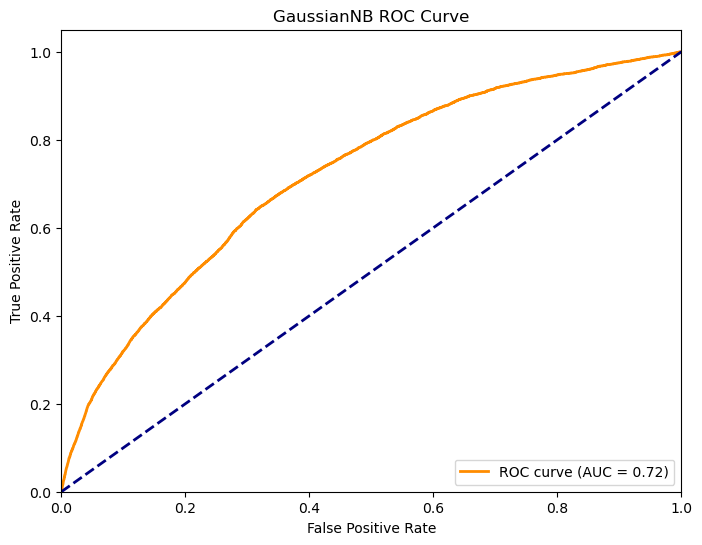

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_naivebayes.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GaussianNB ROC Curve")
plt.legend(loc = "lower right")
plt.show()

In [86]:
from sklearn.ensemble import RandomForestClassifier

model_randomforest = RandomForestClassifier(random_state=42, max_depth = 20, max_features = "sqrt", min_samples_leaf = 1, min_samples_split = 2, n_estimators = 500)
# Fit the model
model_randomforest.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_randomforest.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    102679
           1       0.17      0.70      0.27      8070

    accuracy                           0.72    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.72      0.79    110749



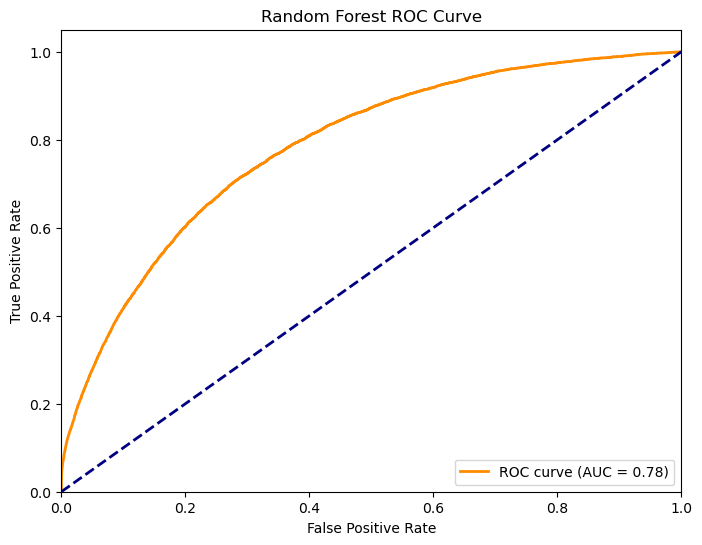

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_randomforest.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc = "lower right")
plt.show()

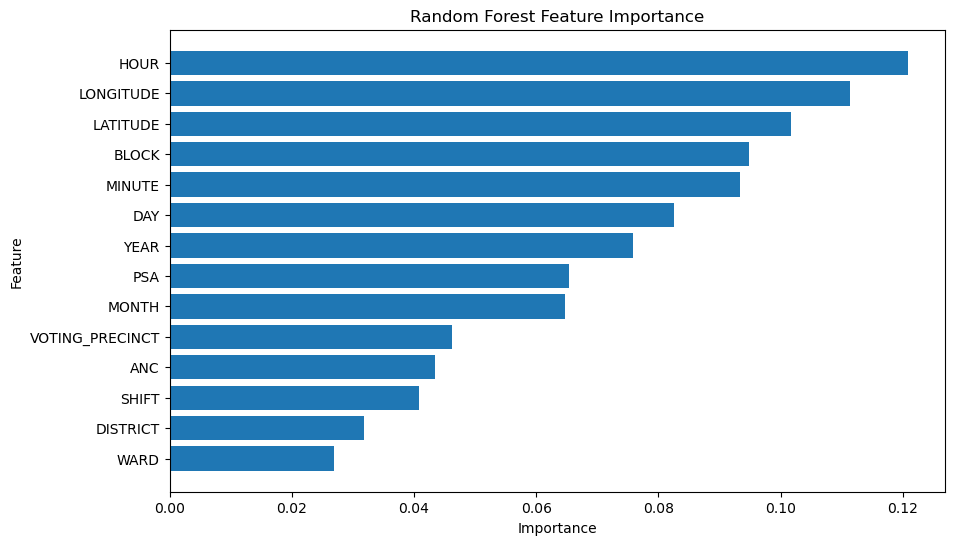

In [88]:
# Get feature importance
importance = model_randomforest.feature_importances_


# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})


# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = True)


# Plot feature importance
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()
